In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
data_dir="D:\DL\Plant Disease\data/"

In [3]:
Plants=[]
for file in os.listdir(data_dir):
    Plants+=[file]
print(Plants)
print(len(Plants))

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']
11


In [4]:
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(Plants):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'LabelID', 'Label'])
train.head()

,File,LabelID,Label
0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
1,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
2,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
3,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...
4,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...


In [5]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))  # Reset indices
train.tail()

,File,LabelID,Label
5109,Tomato___Late_blight/7ee00267-be66-4b6a-a207-0...,9,Tomato___Late_blight
5110,Corn_(maize)___Common_rust_/img (15).JPG,1,Corn_(maize)___Common_rust_
5111,Potato___Late_blight/bd70c718-5846-42a1-8b05-2...,6,Potato___Late_blight
5112,Tomato___healthy/img (182).JPG,8,Tomato___healthy
5113,Corn_(maize)___Common_rust_/img (75).JPG,1,Corn_(maize)___Common_rust_


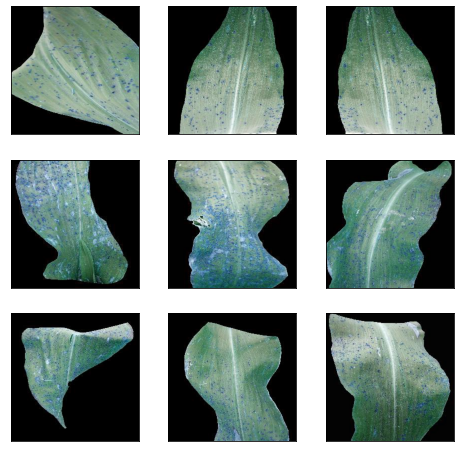

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('Corn_(maize)___Common_rust_', 3, 3)

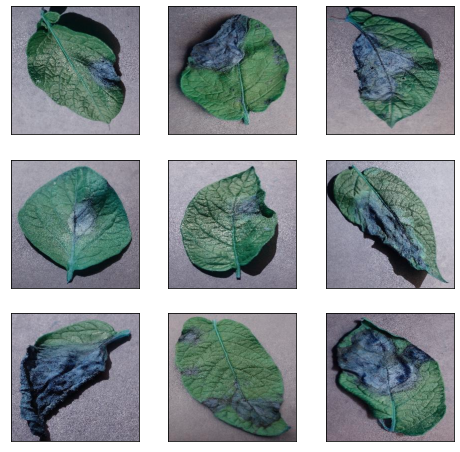

In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('Potato___Late_blight', 3, 3)

In [8]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)


train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    class_mode='categorical')

Found 5114 images belonging to 11 classes.


In [9]:
IMAGE_SIZE = 128


def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))


def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [10]:
x_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        x_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))


x_train = x_train / 255.

num_classes=11
y_train = train['LabelID'].values
y_train = to_categorical(y_train,num_classes)

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=SEED)
print('Train Shape: {}'.format(X_train.shape))
print('Train Shape: {}'.format(Y_train.shape))

5114it [02:52, 29.66it/s]


Train Shape: (3579, 128, 128, 3)
Train Shape: (3579, 11)


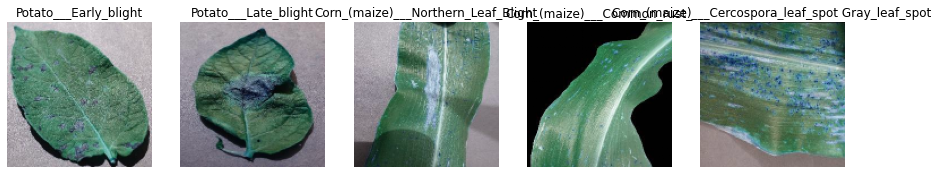

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(Plants[np.argmax(Y_train[i])])

In [12]:
from tensorflow.keras.regularizers import l2

In [13]:
model = Sequential()
model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3, strides = 2,input_shape=(128,128,3)))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size=3))
model.add(MaxPool2D(pool_size=(2,2),strides = 2))

model.add(Flatten())
model.add(Dense(128,activation="relu"))


model.add(Dense(num_classes,kernel_regularizer=l2(0.01),activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1

In [14]:
model.compile(optimizer="adam",loss="squared_hinge", metrics = ['accuracy'])
hist = model.fit(X_train,Y_train,epochs=15,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/15
358/358 [==============================] - 20s 42ms/step - loss: 1.1291 - accuracy: 0.4560 - val_loss: 1.0545 - val_accuracy: 0.6221
Epoch 2/15
358/358 [==============================] - 13s 35ms/step - loss: 1.0214 - accuracy: 0.7122 - val_loss: 0.9998 - val_accuracy: 0.7876
Epoch 3/15
358/358 [==============================] - 13s 36ms/step - loss: 0.9900 - accuracy: 0.8039 - val_loss: 1.0002 - val_accuracy: 0.7759
Epoch 4/15
358/358 [==============================] - 13s 36ms/step - loss: 0.9754 - accuracy: 0.8430 - val_loss: 0.9864 - val_accuracy: 0.8000
Epoch 5/15
358/358 [==============================] - 13s 36ms/step - loss: 0.9653 - accuracy: 0.8704 - val_loss: 0.9744 - val_accuracy: 0.8345
Epoch 6/15
358/358 [==============================] - 14s 39ms/step - loss: 0.9571 - accuracy: 0.8899 - val_loss: 0.9663 - val_accuracy: 0.8612
Epoch 7/15
358/358 [==============================] - 14s 38ms/step - loss: 0.9498 - accuracy: 0.9128 - val_loss: 0.9623 - val_accuracy:

In [15]:
model.evaluate(X_test, Y_test)
model.save("D:\DL\Plant Disease\models\SVC.h5")

48/48 [==============================] - 1s 23ms/step - loss: 0.9439 - accuracy: 0.9173


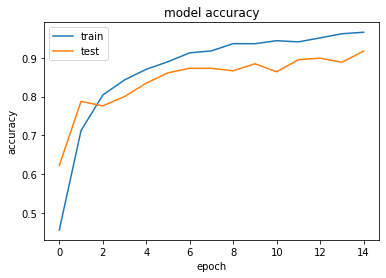

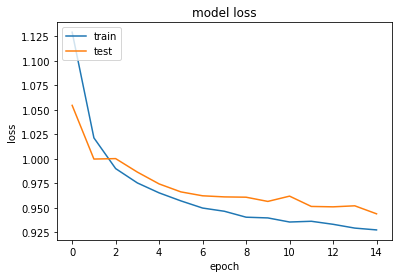

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
from tensorflow import keras

In [18]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [128, 128,3]),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 11)                363       
Total params: 6,302,283
Trainable params: 6,302,283
Non-trainable params: 0
_________________________________________________________________


In [19]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist1=model1.fit(X_train,Y_train,epochs=15,batch_size=5,validation_data=(X_test,Y_test))

Epoch 1/15
716/716 [==============================] - 28s 36ms/step - loss: 2.5233 - accuracy: 0.0852 - val_loss: 2.3981 - val_accuracy: 0.0873
Epoch 2/15
716/716 [==============================] - 27s 38ms/step - loss: 2.3967 - accuracy: 0.0905 - val_loss: 2.3985 - val_accuracy: 0.0925
Epoch 3/15
716/716 [==============================] - 26s 37ms/step - loss: 2.3963 - accuracy: 0.0947 - val_loss: 2.3989 - val_accuracy: 0.0925
Epoch 4/15
716/716 [==============================] - 26s 36ms/step - loss: 2.3962 - accuracy: 0.0858 - val_loss: 2.3990 - val_accuracy: 0.0925
Epoch 5/15
716/716 [==============================] - 25s 35ms/step - loss: 2.3961 - accuracy: 0.0891 - val_loss: 2.3993 - val_accuracy: 0.0925
Epoch 6/15
716/716 [==============================] - 25s 35ms/step - loss: 2.3961 - accuracy: 0.0897 - val_loss: 2.3995 - val_accuracy: 0.0925
Epoch 7/15
716/716 [==============================] - 25s 35ms/step - loss: 2.3962 - accuracy: 0.0877 - val_loss: 2.3996 - val_accuracy:

In [20]:
model1.evaluate(X_test, Y_test)
model1.save("D:\DL\Plant Disease\models\ANN.h5")

48/48 [==============================] - 1s 13ms/step - loss: 2.3997 - accuracy: 0.0906


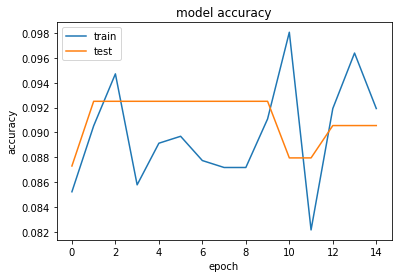

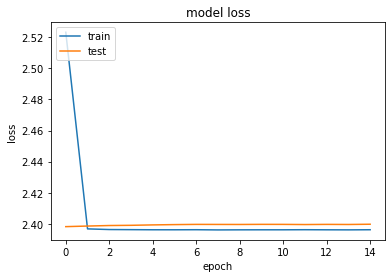

In [21]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model2 = Sequential()

model2.add(Conv2D(128, kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))
model2.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
model2.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 64)      73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 32)      18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 476288)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 11)                5239179   
Total params: 5,335,019
Trainable params: 5,335,019
Non-trainable params: 0
_________________________________________________________________


In [23]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist2=model2.fit(X_train,Y_train,epochs=5,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/5
358/358 [==============================] - 441s 1s/step - loss: 2.0965 - accuracy: 0.3004 - val_loss: 1.8539 - val_accuracy: 0.3818
Epoch 2/5
358/358 [==============================] - 439s 1s/step - loss: 1.6162 - accuracy: 0.4767 - val_loss: 1.6419 - val_accuracy: 0.5081
Epoch 3/5
358/358 [==============================] - 449s 1s/step - loss: 1.1627 - accuracy: 0.6303 - val_loss: 1.7066 - val_accuracy: 0.4938
Epoch 4/5
358/358 [==============================] - 427s 1s/step - loss: 0.7111 - accuracy: 0.7728 - val_loss: 1.9843 - val_accuracy: 0.5479
Epoch 5/5
358/358 [==============================] - 438s 1s/step - loss: 0.3750 - accuracy: 0.8930 - val_loss: 2.9487 - val_accuracy: 0.5485


In [24]:
model2.evaluate(X_test, Y_test)
model2.save("D:\DL\Plant Disease\models\CNN.h5")

48/48 [==============================] - 27s 558ms/step - loss: 2.9487 - accuracy: 0.5485


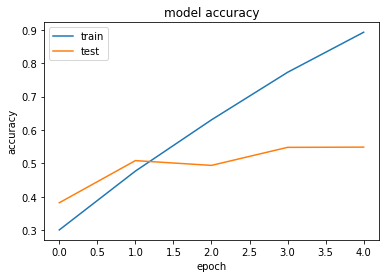

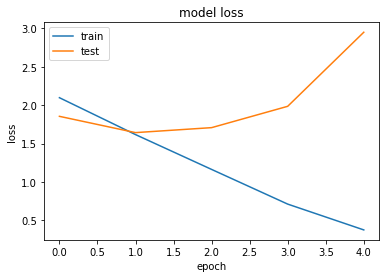

In [25]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
base_model3 = tf.keras.applications.ResNet50(input_shape=(128, 128, 3), include_top=False,
                          weights='imagenet')
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(num_classes, activation='sigmoid'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                131136    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 11)                715       
Total params: 23,719,819
Trainable params: 23,666,571
Non-trainable params: 53,248
_____________________________________

In [27]:
model3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist3=model3.fit(X_train,Y_train,epochs=5,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/5
358/358 [==============================] - 596s 2s/step - loss: 0.8855 - accuracy: 0.7223 - val_loss: 3.7816 - val_accuracy: 0.0873
Epoch 2/5
358/358 [==============================] - 617s 2s/step - loss: 0.4130 - accuracy: 0.8712 - val_loss: 4.3342 - val_accuracy: 0.1010
Epoch 3/5
358/358 [==============================] - 587s 2s/step - loss: 0.3201 - accuracy: 0.8991 - val_loss: 0.4122 - val_accuracy: 0.8723
Epoch 4/5
358/358 [==============================] - 587s 2s/step - loss: 0.2650 - accuracy: 0.9215 - val_loss: 0.9972 - val_accuracy: 0.6671
Epoch 5/5
358/358 [==============================] - 563s 2s/step - loss: 0.2430 - accuracy: 0.9234 - val_loss: 0.8342 - val_accuracy: 0.7407


In [28]:
model3.evaluate(X_test, Y_test)
model3.save("D:\DL\Plant Disease\models\ResNet50.h5")

48/48 [==============================] - 37s 766ms/step - loss: 0.8342 - accuracy: 0.7407


C:\Users\YMTS0427\AppData\Roaming\Python\Python36\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


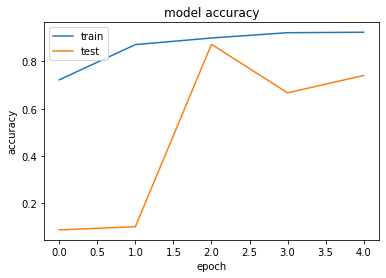

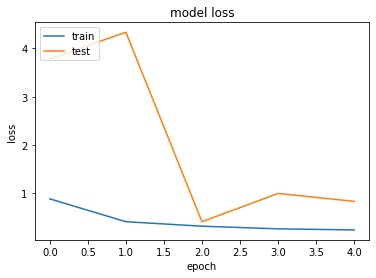

In [29]:
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
Accuracy = []

for i in [hist, hist1, hist2,hist3]:
    x = i.history.get('accuracy')[-1]
    Accuracy.append(x)

Accuracy

[0.9659122824668884,
 0.09192512184381485,
 0.8929868936538696,
 0.9234423041343689]

[0.07606707 0.09031153 0.08990657 0.09644479 0.09393627 0.08955535
 0.09709217 0.08240584 0.09652428 0.0913079  0.09644825]


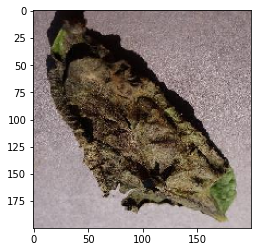

Prediction: Potato___Late_blight


In [39]:
from skimage import io
from keras.preprocessing import image

img = image.load_img(r'D:\DL\Plant Disease\data\Potato___Late_blight\8b0ef54c-6d28-47bb-a657-287afbb8a620___RS_LB 3298.jpg', grayscale=False, target_size=(128,128,3))
show_img=image.load_img(r'D:\DL\Plant Disease\data\Potato___Late_blight\8b0ef54c-6d28-47bb-a657-287afbb8a620___RS_LB 3298.jpg', grayscale=False, target_size=(200, 200,3))
Plants = ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model1.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',Plants[ind])